In [6]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from seaborn import scatterplot
import seaborn as sns
import numpy as np
import requests
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
data_dir = 'data'
or_dir = '../data'
twin_dir = 'data/twin_comparison'
picrust_dir = 'data/picrust_del'

In [8]:
metadata = pd.read_csv(f'{or_dir}/metadata.tsv', sep='\t')

In [9]:
def fetch_ipath(ids: list, img_output_path: str, verbose: bool = False):
    """Fetches a enriched pathways map from iPATH3 for given IDs."""
    url = 'https://pathways.embl.de/mapping.cgi'
    
    # remove colon from EC names
    if ':' in ids[0]:
        ids = [x.replace(':', '') for x in ids]
    
    if verbose:
        print(f'Fetching iPATH3 diagram for ids: {ids}')
    params = {
        'default_opacity': 0.6,
        'export_type': 'svg',
        'selection': '\n'.join(ids)
    }   
    response = requests.get(url=url, params=params)
    
    with open(img_output_path, 'wb') as img:
        img.write(response.content)

In [10]:
# path to the picrust2 conda environment - do not change!
picrust_env = '/opt/conda/envs/picrust2/bin'

In [11]:
%%script env picrust_env="$picrust_env" data_dir="$data_dir" bash

# append the env location to PATH so that qiime
# can find all required executables
export PATH=$picrust_env:$PATH

$picrust_env/qiime picrust2 full-pipeline \
    --i-seq $data_dir/PJNB_dada2_rep_set.qza \
    --i-table $data_dir/PJNB_dada2_table_.qza \
    --output-dir $data_dir/picrust2_results \
    --p-placement-tool sepp \
    --p-threads 2 \
    --p-hsp-method pic \
    --p-max-nsti 2

Saved FeatureTable[Frequency] to: data/picrust2_results/ko_metagenome.qza
Saved FeatureTable[Frequency] to: data/picrust2_results/ec_metagenome.qza
Saved FeatureTable[Frequency] to: data/picrust2_results/pathway_abundance.qza


In [12]:
! qiime metadata tabulate \
    --m-input-file $or_dir/metadata.tsv \
    --o-visualization $data_dir/metadata.qzv

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved Visualization to: data/metadata.qzv


In [18]:
! qiime feature-table filter-samples \
    --i-table $data_dir/picrust2_results/pathway_abundance.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --p-where "[diet_milk]='fd' or [diet_milk]='bd'" \
    --o-filtered-table $data_dir/picrust2_results/pjnb-path-abund-milk.qza

Saved FeatureTable[Frequency] to: data/picrust2_results/pjnb-path-abund-milk.qza


In [19]:
! qiime composition add-pseudocount \
    --i-table $data_dir/picrust2_results/pjnb-path-abund-milk.qza \
    --o-composition-table $data_dir/picrust2_results/pjnb-path-abund-milk-pseudo.qza

Saved FeatureTable[Composition] to: data/picrust2_results/pjnb-path-abund-milk-pseudo.qza


In [25]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pjnb-path-abund-milk-pseudo.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --m-metadata-column diet_milk \
    --p-transform-function log \
    --o-visualization $data_dir/picrust2_results/pa_ancom_milk.qzv

Saved Visualization to: data/picrust2_results/pa_ancom_milk.qzv


In [26]:
Visualization.load(f'{data_dir}/picrust2_results/pa_ancom_milk.qzv')

<visualization: Visualization uuid: 58401a7d-17d9-4ae5-86a5-d446e536a5b7>

In [24]:
! qiime tools extract \
    --input-path $data_dir/pa_ancom_milk.qzv \
    --output-path $data_dir/pa_ancom_milk

Extracted data/pa_ancom_milk.qzv to directory data/pa_ancom_milk/05298a47-f8db-478f-9007-5cd5cc78601c


In [27]:
ancomData = pd.read_csv(f'{data_dir}/pa_ancom_milk/05298a47-f8db-478f-9007-5cd5cc78601c/data/data.tsv', sep='\t')
ancomSignificance = pd.read_csv(f'{data_dir}/pa_ancom_milk/05298a47-f8db-478f-9007-5cd5cc78601c/data/ancom.tsv', sep='\t')
ancomSignificance.rename(columns = {'Unnamed: 0':'id'}, inplace = True)

In [28]:
ancomDataSig = ancomData.merge(ancomSignificance, how='inner')
ancomDataSig

,id,log,W,Reject null hypothesis
0,1CMET2-PWY,-0.007406,167,False
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,-0.793881,378,True
2,AEROBACTINSYN-PWY,-0.402921,24,False
3,ALL-CHORISMATE-PWY,-0.662944,373,True
4,ANAEROFRUCAT-PWY,0.213974,306,False
...,...,...,...,...
458,TYRFUMCAT-PWY,0.099911,30,False
459,UBISYN-PWY,-0.259454,124,False
460,UDPNAGSYN-PWY,-0.042079,139,False
461,VALDEG-PWY,-0.023803,95,False


In [29]:
ancomDataSig.sort_values(by='log', axis=0, ascending=True)

,id,log,W,Reject null hypothesis
61,HCAMHPDEG-PWY,-1.068510,419,True
306,PWY-6690,-1.068510,419,True
80,METHGLYUT-PWY,-0.998851,413,True
428,PWY0-42,-0.991533,412,True
210,PWY-5747,-0.930973,405,True
...,...,...,...,...
98,P163-PWY,1.561653,456,True
78,METH-ACETATE-PWY,1.574535,456,True
101,P221-PWY,1.744462,454,True
400,PWY-7456,1.813920,458,True


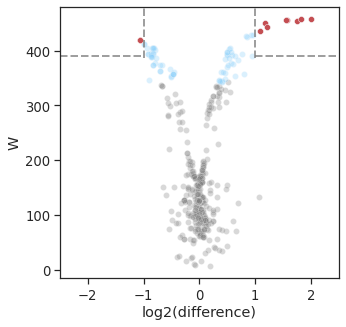

In [31]:
sns.set(rc={'figure.figsize':(5, 5)}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    ax = sns.scatterplot(
        data= ancomDataSig[(ancomDataSig['Reject null hypothesis'] == False)], 
        x='log', 
        y='W',
        color='grey',
        alpha=.3
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']>-1)], 
        x='log', 
        y='W',
        color='lightskyblue',
        alpha=.3
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']<-1)], 
        x='log', 
        y='W',
        color='r'
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']>1)], 
        x='log', 
        y='W',
        color='r'
    )
ax.tick_params(axis='x', which='major', bottom=True)
ax.tick_params(axis='y', which='major', left=True)
ax.set_xlim(-2.5,2.5)
#ax.set_ylim(-5,5200)
#ax.set_yscale('log')
ax.set_xlabel('log2(difference)')
ax.axhline(y=391, xmin=0, xmax=.3, color="grey", dashes=(5, 2))
ax.axhline(y=391, xmin=.7, xmax=1, color="grey", dashes=(5, 2))
ax.axvline(x=1, ymin=0.81, ymax=1, color="grey", dashes=(5, 2))
ax.axvline(x=-1, ymin=0.81, ymax=1, color="grey", dashes=(5, 2))
ax.set_ylabel('W')
plt.savefig(f'{data_dir}/figures/Volcano_picrustMilk_600dpi.png', bbox_inches='tight', dpi=600)